# Проект e-commerce
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

Сохраним датафреймы с данными о продажах

In [2]:
olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv') #уникальные идентификаторы пользователей
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv') #заказы
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv') #товарные позиции, входящие в заказы

# Предварительное исследование данных

In [3]:
#размер таблицы с уникальными идентификаторами пользователей
print('{} rows; {} columns'.format(olist_customers_dataset.shape[0], olist_customers_dataset.shape[1]))

99441 rows; 5 columns


In [4]:
print('уникальное количество клиентов: {}'.format(olist_customers_dataset.customer_unique_id.nunique()))

уникальное количество клиентов: 96096


In [5]:
#размер таблицы с заказами 
print('{} rows; {} columns'.format(olist_orders_dataset.shape[0], olist_orders_dataset.shape[1]))

99441 rows; 8 columns


In [6]:
print('уникальное количество заказов: {}'.format(olist_orders_dataset.order_id.nunique()))

уникальное количество заказов: 99441


In [7]:
#размер таблицы с товарными позициями, входящими в заказы
print('{} rows; {} columns'.format(olist_order_items_dataset.shape[0], olist_order_items_dataset.shape[1]))

112650 rows; 7 columns


In [8]:
print('уникальное количество заказов: {}'.format(olist_order_items_dataset.order_id.nunique()))

уникальное количество заказов: 98666


в таблице olist_order_items_dataset на каждый товар имеется отдельная строка

# Подготовка данных

In [9]:
#Проверим тип данных в датасете с заказами
olist_orders_dataset.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [10]:
#Проверим тип данных в датасете с уникальными идентификаторами пользователей
olist_orders_dataset.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [11]:
#Проверим тип данных в датасете с товарными позициями, входящие в заказы
olist_order_items_dataset.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [12]:
#найденные даты конвертируем в формат datetime
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset.order_purchase_timestamp)
olist_orders_dataset['order_approved_at'] = pd.to_datetime(olist_orders_dataset.order_approved_at)
olist_orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(olist_orders_dataset.order_delivered_carrier_date)
olist_orders_dataset['order_delivered_customer_date'] = pd.to_datetime(olist_orders_dataset.order_delivered_customer_date)
olist_orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_dataset.order_estimated_delivery_date)
olist_order_items_dataset['shipping_limit_date'] = pd.to_datetime(olist_order_items_dataset.shipping_limit_date)

In [13]:
#создадим датафрейм, который содержит информацию со всех 3 датафреймов
customers_orders = olist_customers_dataset.merge(olist_orders_dataset, 
                                                 how='left',
                                                 on='customer_id')
customers_orders_detailed = customers_orders.merge(olist_order_items_dataset, 
                            how='left',
                            on='order_id')

In [14]:
#проверим пустые значения
customers_orders_detailed.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
dtype: int64

order_approved_at                 

In [15]:
#проверим при каких статусах, могут отсутвовать время подтверждения оплаты заказа (order_approved_at)
customers_orders_detailed.query("order_approved_at.isnull()").order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

In [16]:
#у 15 заказов стоит статус доставлено, при этом нет даты подтверждения оплаты заказа
#сохраним в отдельный список delivered_wo_approved_at
delivered_wo_approved_at = customers_orders_detailed \
.query("order_status == 'delivered' and order_approved_at.isnull()") \
.order_id
delivered_wo_approved_at.shape

(15,)

order_delivered_carrier_date

In [17]:
#проверим при каких статусах, могут отсутвовать время передачи заказа в логистическую службу (order_delivered_carrier_date)
customers_orders_detailed.query("order_delivered_carrier_date.isnull()").order_status.unique()

array(['canceled', 'invoiced', 'processing', 'unavailable', 'approved',
       'created', 'delivered'], dtype=object)

In [18]:
#у 2х заказов стоит статус доставлено, при этом нет даты передачи на  в логистическую службу
#сохраним в отдельный список delivered_wo_carrier_date
delivered_wo_carrier_date = customers_orders_detailed \
.query("order_status == 'delivered' and order_delivered_carrier_date.isnull()") \
.order_id
delivered_wo_carrier_date.shape

(2,)

order_delivered_customer_date

In [19]:
#проверим при каких статусах, могут отсутвовать время  (order_delivered_customer_date)
customers_orders_detailed.query("order_delivered_customer_date.isnull()").order_status.unique()

array(['canceled', 'invoiced', 'shipped', 'processing', 'unavailable',
       'approved', 'delivered', 'created'], dtype=object)

In [20]:
#у 8ми заказов стоит статус доставлено, при этом нет даты доставки заказа
#сохраним в отдельный список delivered_wo_customer_date
delivered_wo_customer_date = customers_orders_detailed \
.query("order_status == 'delivered' and order_delivered_customer_date.isnull()") \
.order_id
delivered_wo_customer_date.shape

(8,)

order_item_id

In [21]:
#проверим при каких статусах, могут отсутвовать товарные позиции, входящие в заказы
customers_orders_detailed.query("order_item_id.isnull()").order_status.unique()

array(['canceled', 'unavailable', 'created', 'shipped', 'invoiced'],
      dtype=object)

предполагаем, что при статусах ['canceled', 'unavailable'] возможно наличие пустых значений
однако есть сомнения в статусах ['created','shipped', 'invoiced']

In [22]:
#всего 8 заказов, где не предполагается отсутствие товаров ['created','shipped', 'invoiced']
#внесем их в отдельный список orders_wo_products
orders_wo_products = customers_orders_detailed \
.query("order_status in ('created','shipped', 'invoiced') and order_item_id.isnull()") \
.order_id
orders_wo_products.shape

(8,)

In [23]:
#сохраним все заказы выше созданные df в not_enough_data
not_enough_data = pd.concat([delivered_wo_approved_at, 
                             delivered_wo_carrier_date, 
                             delivered_wo_customer_date, 
                             orders_wo_products])

# Предварительное исследование данных - Статус покупки

Иследуем полученный датасет customers_orders_detailed для определения что должно считаться покупой 

In [24]:
#у каждого заказа имеется только 1 уникальный статус
customers_orders_detailed.groupby('order_id', as_index = False) \
                         .agg({'order_status': pd.Series.nunique}) \
                         .sort_values('order_status', ascending = False) \
                         .head()

order_id  order_status
0      00010242fe8c5a6d1ba2dd792cb16214             1
66279  ab291c01a71273689c1e6ea624b083dc             1
66301  ab344aaf7040ad7bcee8c7ae7db9e87e             1
66300  ab30f8d4ebb7d33d1dcf54d420ea42cd             1
66299  ab30f399d360ddf62897051d813f887d             1

статусы нельзя использовать для определения покупки

отражают состояние заказа только на момент выгрузки

необходим более стабильный параметр (неизменчивый)

начнем с order_approved_at - время подтверждения оплаты заказа

предполагаем что каждая покупка должна сопровождаться транзакцией и ее потверждением

In [25]:
#проверим при каких статусах есть заполненный order_approved_at
customers_orders_detailed.query("order_approved_at != ''") \
                         .order_status \
                         .value_counts()

delivered      110182
shipped          1186
unavailable       610
canceled          565
invoiced          361
processing        357
approved            3
Name: order_status, dtype: int64

есть некоторые заказы, которые были отменены после оплаты


In [26]:
#также есть ли 3 оплаченных заказа без товаров
purchase_wo_products = customers_orders_detailed.query("order_approved_at != '' and order_id in @orders_wo_products") \
                       .order_id
purchase_wo_products.shape

(3,)

для статуса покупки будет использоваться order_approved_at

однако стоит учитывать, что есть заказы которые были
    - неоплачены и доставлены (delivered_wo_approved_at)
    - оплачены, но без товаров в заказе
    - отменены после оплаты (canceled)
    - заказы с недоступными товарами (unavailable)
было решено создать датафрейм без их учета 

In [27]:
verified_purchases = customers_orders_detailed \
.query("order_approved_at != '' and order_id not in @delivered_wo_approved_at and order_id not in @purchase_wo_products and order_status not in ('canceled', 'unavailable')")

# Анализ

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

In [28]:
verified_purchases.groupby('customer_unique_id', as_index = False) \
                  .agg({'customer_id': pd.Series.nunique}) \
                  .query("customer_id == 1") \
                  .agg({'customer_unique_id':'count'})

customer_unique_id    92084
dtype: int64

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [29]:
#рассмотрим заказы, которые не были доставлены
customers_orders_detailed \
.query("order_delivered_customer_date.isnull()") \
.order_status \
.value_counts()

shipped        1186
canceled        699
unavailable     610
invoiced        361
processing      357
delivered         8
created           5
approved          3
Name: order_status, dtype: int64

In [30]:
#в случае если товар отгружен, заполняется параметр order_delivered_carrier_date
#рассмотрим заказы, которые не были доставлены, но были отгружены со склада
customers_orders_detailed \
.query("order_delivered_customer_date.isnull() and order_delivered_carrier_date.isna() == False") \
.order_status \
.value_counts()

shipped      1186
canceled       69
delivered       7
Name: order_status, dtype: int64

по полученным данным, заказы могли быть недоставлены в случае если;
 - заказ был отменен (canceled)
 - товара не было в наличии (unavailable)
 - ошибка в бд (7 доставленных заказов не имеют дату доставки)

в остальных случаях, заказ или еще не был собран или не был отгружен

In [31]:
undelivered = customers_orders_detailed.query(
"(order_delivered_customer_date.isnull() and order_delivered_carrier_date.isna() == False and order_status == 'delivered') or order_status in ('canceled', 'unavailable')")

In [32]:
#Сколько заказов в месяц в среднем не доставляется по разным причинам 
undelivered.groupby([undelivered.order_status, 
                     undelivered.order_approved_at.dt.strftime("%Y %m")]) \
.agg({'order_id' : 'count'}) \
.rename(columns = {'order_id': 'orders'}) \
.groupby('order_status') \
.agg({'orders' : 'mean'}) \
.round(2)

orders
order_status        
canceled       26.90
delivered       2.33
unavailable    29.05

В среднем 
27 заказов не доставляется по причине отмены
29 заказов по причине, товаров не было в наличии
2 заказа в месяц доставлены, но содержат пустое поле даты доставки

По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [33]:
#создаем столбец с датой покупки в виде дня недели
verified_purchases['order_approved_at_name'] =  verified_purchases['order_approved_at'] \
                                                .dt.day_name() 

C:\Users\DIANAM~1\AppData\Local\Temp/ipykernel_15764/2352373353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_purchases['order_approved_at_name'] =  verified_purchases['order_approved_at'] \


In [34]:
#создаем датафрейм с количеством заказов в группировке по товару и дню недели
df = verified_purchases.groupby('product_id') \
.agg({"order_approved_at_name": "value_counts"}) \
.rename(columns = {'order_approved_at_name' : 'orders'}) \
.reset_index()

In [35]:
df.head()

product_id order_approved_at_name  orders
0  00066f42aeeb9f3007548bb9d3f33c38                 Sunday       1
1  00088930e925c41fd95ebfe695fd2655                Tuesday       1
2  0009406fd7479715e4bef61dd91f2462                 Friday       1
3  000b8f95fcb9e0096488278317764d19                 Friday       1
4  000b8f95fcb9e0096488278317764d19              Wednesday       1

In [36]:
#создаем датафрейм со списком товаров и количеством заказов за каждый день недели 
#в случае если в разные дни недели купили одинакое количество товаров, то эти дни недели идут в одной ячейке
df_concat = df.groupby(['product_id', 'orders'], 
                       as_index = False) \
              .agg({'order_approved_at_name': ' '.join})

In [37]:
df_concat.head()

product_id  orders order_approved_at_name
0  00066f42aeeb9f3007548bb9d3f33c38       1                 Sunday
1  00088930e925c41fd95ebfe695fd2655       1                Tuesday
2  0009406fd7479715e4bef61dd91f2462       1                 Friday
3  000b8f95fcb9e0096488278317764d19       1       Friday Wednesday
4  000d9be29b5207b54e86aa1b1ac54872       1                Tuesday

In [38]:
#создаем датафрейм с максимальным количеством заказов на каждый товар
df_max = df_concat.groupby('product_id',as_index = False).agg({'orders': 'max'})
df_max

product_id  orders
0      00066f42aeeb9f3007548bb9d3f33c38       1
1      00088930e925c41fd95ebfe695fd2655       1
2      0009406fd7479715e4bef61dd91f2462       1
3      000b8f95fcb9e0096488278317764d19       1
4      000d9be29b5207b54e86aa1b1ac54872       1
...                                 ...     ...
32721  fff6177642830a9a94a0f2cba5e476d1       1
32722  fff81cc3158d2725c0655ab9ba0f712c       1
32723  fff9553ac224cec9d15d49f5a263411f       1
32724  fffdb2d0ec8d6a61f0a0a0db3f25b441       3
32725  fffe9eeff12fcbd74a2f2b007dde0c58       1

[32726 rows x 2 columns]

создаем датафрейм, который содержит в себе 2 таблицы
   -  df_concat
   -  df_max

по итогу получаем таблицy df_merge
 - айди товара (product_id)
 - максимальное количество заказов на 1 день (values)
 - список дней недели, когда было совершено максимальное количество заказов


In [39]:
df_merge = df_concat.merge(df_max, how = 'inner', on = ['product_id', 'orders'])
df_merge.head()

product_id  orders order_approved_at_name
0  00066f42aeeb9f3007548bb9d3f33c38       1                 Sunday
1  00088930e925c41fd95ebfe695fd2655       1                Tuesday
2  0009406fd7479715e4bef61dd91f2462       1                 Friday
3  000b8f95fcb9e0096488278317764d19       1       Friday Wednesday
4  000d9be29b5207b54e86aa1b1ac54872       1                Tuesday

 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [40]:
#создаем столбец с количеством дней в месяце и дата покупки в виде месяца
verified_purchases['days_month'] = verified_purchases['order_approved_at'].dt.days_in_month
verified_purchases['year_month'] = verified_purchases['order_approved_at'].dt.strftime('%m/%Y')

C:\Users\DIANAM~1\AppData\Local\Temp/ipykernel_15764/2129929721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_purchases['days_month'] = verified_purchases['order_approved_at'].dt.days_in_month
C:\Users\DIANAM~1\AppData\Local\Temp/ipykernel_15764/2129929721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_purchases['year_month'] = verified_purchases['order_approved_at'].dt.strftime('%m/%Y')


In [41]:
#создаем столбец с количеством недель в месяце
verified_purchases['weeks_month'] = verified_purchases['days_month']/4

C:\Users\DIANAM~1\AppData\Local\Temp/ipykernel_15764/2295527819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_purchases['weeks_month'] = verified_purchases['days_month']/4


In [42]:
verified_purchases.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ... order_item_id  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...           1.0   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...           1.0   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...           1.0   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...           1.0   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...           1.0   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

  shipping_limit_date   price freight_value  order_approved_at_name  \
0 2017-05-22 15:22:12  124.99         21.88                 Tuesday   
1 2018-01-18 20:58:32  289.00         46.48                  Friday   
2 2018-06-05 16:19:10  139.94         17.79                  Sunday   
3 2018-03-27 16:31:16  149.94         23.36                 Tuesday   
4 2018-07-31 10:10:09  230.00         22.25                  Sunday   

   days_month year_month  weeks_month  
0          31    05/2017         7.75  
1          31    01/2018         7.75  
2          31    05/2018         7.75  
3          31    03/2018         7.75  
4          31    07/2018         7.75  

[5 rows x 22 columns]

In [43]:
#создаем таблицу с количеством заказов на каждого клиента и месяц покупки (также добавлен столбец с количеством недель в месяце)
purchases_month = verified_purchases.groupby(['year_month', 'customer_unique_id', 'days_month']) \
.agg({"order_id":  pd.Series.nunique}) \
.reset_index() \
.rename(columns = {'order_id': 'orders'}) \
.sort_values('orders', ascending = False)

In [44]:
#добавляем столбец со ср количеством заказов в неделю
purchases_month['avg_week'] = (purchases_month['orders']/purchases_month['days_month']).round(2)
purchases_month.head()

year_month                customer_unique_id  days_month  orders  \
60       01/2017  12f5d6e1cbf93dafd9dcc19095df0b3d          31       6   
25948    04/2017  25a560b9a6006157838aab1bdbd68624          30       4   
11009    02/2018  3e43e6105506432c953e165fb2acf44c          28       4   
372      01/2017  83e7958a94bd7f74a9414d8782f87628          31       4   
13997    02/2018  b4e4f24de1e8725b74e4a1f4975116ed          28       4   

       avg_week  
60         0.19  
25948      0.13  
11009      0.14  
372        0.13  
13997      0.14

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

Размер когорты — месяц

Отчетный период — 3й месяц

Анализируемый ключевой показатель: Retention Rate

в данном случае Retention Rate будет долей удержания клиентов от первого до второго заказа на 3 месяц после первого заказа

In [45]:
#найдем на каждого клиента дату его первого заказа
first_purchase = verified_purchases.groupby('customer_unique_id') \
.agg({'order_approved_at' : 'min'}) \
.reset_index()

In [46]:
#создадим таблицу с данными всех заказов клиентов и столбцом с датой его первой покупки
purchase_merge = verified_purchases.merge(first_purchase, how = 'left', on = 'customer_unique_id')
purchase_merge.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

  order_approved_at_x order_delivered_carrier_date  ...  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

   shipping_limit_date   price freight_value order_approved_at_name  \
0  2017-05-22 15:22:12  124.99         21.88                Tuesday   
1  2018-01-18 20:58:32  289.00         46.48                 Friday   
2  2018-06-05 16:19:10  139.94         17.79                 Sunday   
3  2018-03-27 16:31:16  149.94         23.36                Tuesday   
4  2018-07-31 10:10:09  230.00         22.25                 Sunday   

   days_month  year_month weeks_month  order_approved_at_y  
0          31     05/2017        7.75  2017-05-16 15:22:12  
1          31     01/2018        7.75  2018-01-12 20:58:32  
2          31     05/2018        7.75  2018-05-20 16:19:10  
3          31     03/2018        7.75  2018-03-13 17:29:19  
4          31     07/2018        7.75  2018-07-29 10:10:09  

[5 rows x 23 columns]

In [47]:
#создаем столбцы с месяцем и годом первой покупки
purchase_merge['month_first_purch'] = purchase_merge['order_approved_at_y'].dt.month
purchase_merge['year_first_purch'] = purchase_merge['order_approved_at_y'].dt.year

In [48]:
#определяем сколько месяцев прошло с момента первой покупки
purchase_merge['order_approved_diff'] = np.ceil((purchase_merge['order_approved_at_x']-purchase_merge['order_approved_at_y']) \
                                        .dt.total_seconds() / 2592000) #делим на количество секунд в месяце

In [49]:
#создаем df с количеством игроков в разбивке по месяцу заказа и по месяцу первой покупки
return_users = purchase_merge.groupby(['year_first_purch','month_first_purch','order_approved_diff']) \
.agg({'customer_unique_id' : pd.Series.nunique}) \
.reset_index()

In [50]:
#меняем отображение таблицы с помощью pivot
return_users_pivot = return_users.query("order_approved_diff <= 3") \
                                 .pivot(index=['year_first_purch','month_first_purch'], 
                                        columns='order_approved_diff', 
                                        values='customer_unique_id') \
                                 .fillna(0)

In [51]:
#получаем таблицу с данными - сколько игроков совершили покупки в течении 3х месяцев после первой покупки 
#в разбивке по когортам
return_users_pivot

order_approved_diff                    0.0    1.0   2.0   3.0
year_first_purch month_first_purch                           
2016             9                     1.0    0.0   0.0   0.0
                 10                  288.0    3.0   0.0   0.0
                 12                    1.0    1.0   0.0   0.0
2017             1                   716.0   23.0   2.0   0.0
                 2                  1674.0   20.0   3.0   3.0
                 3                  2580.0   40.0   7.0  12.0
                 4                  2301.0   33.0   8.0   6.0
                 5                  3543.0   72.0  16.0  15.0
                 6                  3110.0   62.0  13.0  14.0
                 7                  3776.0   75.0  13.0   8.0
                 8                  4154.0   80.0  27.0  11.0
                 9                  4097.0   83.0  20.0  20.0
                 10                 4360.0   71.0  27.0   4.0
                 11                 7053.0  120.0  26.0  19.0
                 12                 5591.0   64.0  16.0  19.0
2018             1                  6878.0  101.0  25.0  21.0
                 2                  6335.0  146.0  21.0  22.0
                 3                  7009.0  102.0  29.0  12.0
                 4                  6542.0   72.0  30.0  10.0
                 5                  6774.0   67.0  21.0  22.0
                 6                  5916.0   45.0  21.0   5.0
                 7                  5915.0   75.0   7.0   0.0
                 8                  6356.0   37.0   0.0   0.0

In [52]:
#для получения ретеншн, делим игроков совершивших повторные заказы на тех кто совершил хотя бы 1 заказ по когортам
retention = (return_users_pivot[[1,2,3]].div(return_users_pivot[0], axis=0)*100).round(2)

In [53]:
retention = retention.reset_index()
retention.rename(columns = {1 : '1', 2: '2', 3 :'3'})

order_approved_diff  year_first_purch  month_first_purch       1     2     3
0                                2016                  9    0.00  0.00  0.00
1                                2016                 10    1.04  0.00  0.00
2                                2016                 12  100.00  0.00  0.00
3                                2017                  1    3.21  0.28  0.00
4                                2017                  2    1.19  0.18  0.18
5                                2017                  3    1.55  0.27  0.47
6                                2017                  4    1.43  0.35  0.26
7                                2017                  5    2.03  0.45  0.42
8                                2017                  6    1.99  0.42  0.45
9                                2017                  7    1.99  0.34  0.21
10                               2017                  8    1.93  0.65  0.26
11                               2017                  9    2.03  0.49  0.49
12                               2017                 10    1.63  0.62  0.09
13                               2017                 11    1.70  0.37  0.27
14                               2017                 12    1.14  0.29  0.34
15                               2018                  1    1.47  0.36  0.31
16                               2018                  2    2.30  0.33  0.35
17                               2018                  3    1.46  0.41  0.17
18                               2018                  4    1.10  0.46  0.15
19                               2018                  5    0.99  0.31  0.32
20                               2018                  6    0.76  0.35  0.08
21                               2018                  7    1.27  0.12  0.00
22                               2018                  8    0.58  0.00  0.00

In [54]:
#месяцы с самым высоким retention rate по годам
retention.sort_values(3, ascending = False) \
         .groupby(['year_first_purch']) \
         .head(1) \
         .sort_values('year_first_purch')

order_approved_diff  year_first_purch  month_first_purch   1.0   2.0   3.0
0                                2016                  9  0.00  0.00  0.00
11                               2017                  9  2.03  0.49  0.49
16                               2018                  2  2.30  0.33  0.35

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.
В кластеризации можешь выбрать следующие метрики: 

 - R - время от последней покупки пользователя до текущей даты, 
 - F - суммарное количество покупок у пользователя за всё время, 
 - M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. 
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Пример такого описания: 
 - RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик 
 - recency от 130 до 500 дней, 
 - frequency от 2 до 5 заказов в неделю, 
 - monetary от 1780 до 3560 рублей в неделю. 

Описание подхода можно найти тут. (35 баллов)

# Подготовка данных

In [55]:
verified_purchases.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ... order_item_id  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...           1.0   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...           1.0   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...           1.0   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...           1.0   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...           1.0   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

  shipping_limit_date   price freight_value  order_approved_at_name  \
0 2017-05-22 15:22:12  124.99         21.88                 Tuesday   
1 2018-01-18 20:58:32  289.00         46.48                  Friday   
2 2018-06-05 16:19:10  139.94         17.79                  Sunday   
3 2018-03-27 16:31:16  149.94         23.36                 Tuesday   
4 2018-07-31 10:10:09  230.00         22.25                  Sunday   

   days_month year_month  weeks_month  
0          31    05/2017         7.75  
1          31    01/2018         7.75  
2          31    05/2018         7.75  
3          31    03/2018         7.75  
4          31    07/2018         7.75  

[5 rows x 22 columns]

Посчитаем тотал цену для каждого товара

In [56]:
verified_purchases['Revenue'] = verified_purchases['price'] * verified_purchases['freight_value']

C:\Users\DIANAM~1\AppData\Local\Temp/ipykernel_15764/3912706123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verified_purchases['Revenue'] = verified_purchases['price'] * verified_purchases['freight_value']


In [57]:
period = (verified_purchases['order_approved_at'].max() - verified_purchases['order_approved_at'].min()).days
print('Рассматриваемый период: {} days'.format(period))

Рассматриваемый период: 718 days


Как уже известно в на каждый товар в заказе летит отдельный лог, поэтому создадим отдельный датафрейм, где будет суммарная стоимость по каждому заказу

In [58]:
orders = verified_purchases.groupby(['order_id', 'order_approved_at', 'customer_unique_id']) \
                           .agg({'Revenue': lambda x: x.sum()}) \
                           .reset_index()
orders.head()

order_id   order_approved_at  \
0  00010242fe8c5a6d1ba2dd792cb16214 2017-09-13 09:45:35   
1  00018f77f2f0320c557190d7a144bdd3 2017-04-26 11:05:13   
2  000229ec398224ef6ca0657da4fc703e 2018-01-14 14:48:30   
3  00024acbcdf0a6daa1e931b038114c75 2018-08-08 10:10:18   
4  00042b26cf59d7ce69dfabb4e55b4fd9 2017-02-04 14:10:13   

                 customer_unique_id    Revenue  
0  871766c5855e863f6eccc05f988b23cb   782.7810  
1  eb28e67c4c0b83846050ddfb8a35d051  4781.2070  
2  3818d81c6709e39d06b2738a8d3a2474  3556.1300  
3  af861d436cfc08b2c2ddefd0ba074622   166.1421  
4  64b576fb70d441e8f1b2d7d446e483c5  3626.1860

установив NOW дату на один день после последней покупки. Эта дата будет использоваться в качестве ориентира для подсчета Recency.

In [59]:
NOW = orders['order_approved_at'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 17:40:06')

Добавим столбец с количеством дней между покупкой и параметром NOW. Чтобы найти значения Recency, мне просто нужно найти минимум этого столбца для каждого клиента.

In [60]:
orders['DaysSinceOrder'] = orders['order_approved_at'].apply(lambda x: (NOW - x).days)

# Рассчет RFM

In [61]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'order_approved_at': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_approved_at': 'Frequency'}, inplace=True)
rfm.head()

customer_unique_id  Recency  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2      117          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1
2  0000f46a3911fa3c0805444483337064      542          1
3  0000f6ccb0745a6a4b88665a16c9f078      326          1
4  0004aac84e0df4da2b147fca70cf8255      293          1

Добавим Monetary для каждого клиента, добавив продажи за рассматриваемый период

In [68]:
monetary = orders.groupby('customer_unique_id') \
      .agg({'Revenue' : 'sum'}) \
      .reset_index() \
      .rename(columns = {'Revenue' : 'Monetary'})

In [69]:
rfm = rfm.merge(monetary, 
          how='left',
          on='customer_unique_id')

In [70]:
rfm.head()

customer_unique_id  Recency  Frequency   Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      117          1  1558.8000
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1   156.6810
2  0000f46a3911fa3c0805444483337064      542          1  1188.1800
3  0000f6ccb0745a6a4b88665a16c9f078      326          1   458.2037
4  0004aac84e0df4da2b147fca70cf8255      293          1  3040.2000

# Построить границы метрик recency, frequency и monetary 

Для границ метрик будет использоваться метод квинтилей

Получим квинтили для каждой метрики

In [71]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 532.9295999999999,
  0.4: 1058.433,
  0.6: 1919.8738999999998,
  0.8: 3897.0}}

Далее присвоим ранги от 1 до 5. 

Для Recency чем меньше параметр, тем выше будет оценка и наоборот для Frequency и Monetary. 

Для этого будет написано два отдельных метода.

In [72]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

Получаем границы метрик R, F и M для каждого клиента

In [73]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

# Создание кластеров для каждого RFM-сегмента

Объединяю R, F и M в отдельный столбец Score

In [77]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

customer_unique_id  Recency  Frequency   Monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2      117          1  1558.8000  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1   156.6810  4  1  1   
2  0000f46a3911fa3c0805444483337064      542          1  1188.1800  1  1  3   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1   458.2037  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255      293          1  3040.2000  2  1  4   

  RFM Score  
0       413  
1       411  
2       113  
3       211  
4       214

In [78]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

customer_unique_id  Recency  Frequency   Monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2      117          1  1558.8000  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1   156.6810  4  1  1   
2  0000f46a3911fa3c0805444483337064      542          1  1188.1800  1  1  3   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1   458.2037  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255      293          1  3040.2000  2  1  4   

  RFM Score      Segment  
0       413    promising  
1       411    promising  
2       113  hibernating  
3       211  hibernating  
4       214  hibernating

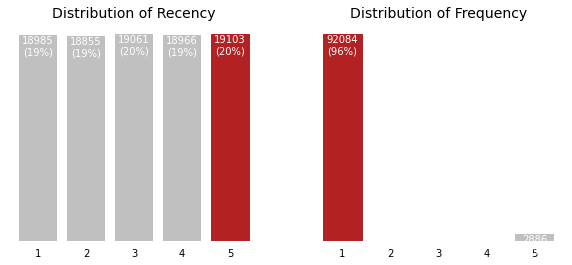

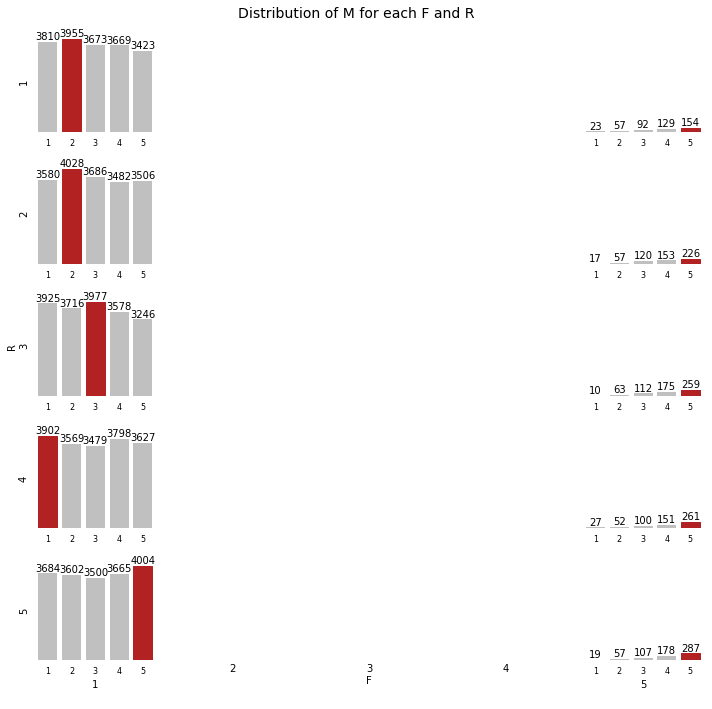

In [79]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()